In [1]:
# ! pip install matplotlib seaborn numpy pandas  

In [43]:
import pandas as pd
from datetime import datetime, timedelta
import time
import requests  
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.interpolate import UnivariateSpline
import os
import subprocess
from rich.jupyter import print
from rich.prompt import Prompt
from constants import OUTDATA_DIR

REQUEST_COLOR = "#8E6A1A"
CONCURRENCY_COLOR = "#37795D"
BG_COLOR = "#F5EFF9"
LABELPAD=8

custom_params = {
    "axes.spines.left": False, 
    "axes.spines.right": False, 
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.grid": False,
    "axes.facecolor": BG_COLOR,
    "figure.facecolor": BG_COLOR
}
sns.set_theme(rc=custom_params)

sm = plt.cm.ScalarMappable(cmap=request_map_for_colorbar, norm=plt.Normalize(vmin=alpha_bottom, vmax=alpha_top))
sm.set_array([])

In [4]:
def create_mapping_function(a, b, _max = 250, _min = 10):
    def mapping_function(x):
        if x < a or x > b:
            raise ValueError(f"The input number {x} is out of the range [{a}, {b}]")
        return _min + (x - a) * (_max - _min) / (b - a)
    return mapping_function

def create_alpha_colormap(hex_color, alpha_bottom, alpha_top):
    rgb_color = to_rgba(hex_color)[:3] 
    return LinearSegmentedColormap.from_list(
        'alpha_colormap',
        [(rgb_color[0], rgb_color[1], rgb_color[2], alpha_bottom),
         (rgb_color[0], rgb_color[1], rgb_color[2], alpha_top)]
    )

In [12]:
default_path_candidates

['results_nvidia_a100-pcie-40gb_2024-06-08_23:58:34_transparent.png',
 'results_nvidia_a100-pcie-40gb_2024-06-08_23:58:34.png']

In [13]:
default_path_candidates = os.listdir(OUTDATA_DIR)
default_path = [os.path.join(OUTDATA_DIR, p) for p in default_path_candidates if p.endswith('_results.csv')][0]
data_path = Prompt.ask("Which data are you analyzing?", default=default_path)

Which data are you analyzing? (latest-data/nvidia_a100-pcie-40gb_results.csv):

In [14]:
df=pd.read_csv(data_path)
df = df[df.prompt_tokens>45589] # some tiny experiments in the raw data.
df['total_tokens'] = df.prompt_tokens + df.completion_tokens
df

,prompt_tokens,completion_tokens,total_requests,total_time,concurrent_requests,n_requests_per_thread,max_tokens_per_request,start_ts,end_ts,device,total_tokens
0,293868,9970,100,180.794247,1,100,100,1.717876e+09,1.717876e+09,nvidia_a100-pcie-40gb,303838
1,303743,33156,100,542.616125,1,100,500,1.717876e+09,1.717876e+09,nvidia_a100-pcie-40gb,336899
2,327041,50270,100,813.932914,1,100,1000,1.717876e+09,1.717877e+09,nvidia_a100-pcie-40gb,377311
3,1618254,49381,500,331.580526,5,100,100,1.717877e+09,1.717878e+09,nvidia_a100-pcie-40gb,1667635
4,1697695,164827,500,817.188819,5,100,500,1.717878e+09,1.717878e+09,nvidia_a100-pcie-40gb,1862522
5,1539572,255384,500,1172.759938,5,100,1000,1.717878e+09,1.717880e+09,nvidia_a100-pcie-40gb,1794956
6,3137522,99278,1000,503.801462,10,100,100,1.717880e+09,1.717880e+09,nvidia_a100-pcie-40gb,3236800
7,3023989,334396,1000,1089.979239,10,100,500,1.717880e+09,1.717881e+09,nvidia_a100-pcie-40gb,3358385
8,3175351,519270,1000,1590.734252,10,100,1000,1.717881e+09,1.717883e+09,nvidia_a100-pcie-40gb,3694621
9,6282483,198474,2000,906.627922,20,100,100,1.717883e+09,1.717884e+09,nvidia_a100-pcie-40gb,6480957


In [15]:
result = subprocess.run(
    ['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    check=True,
    text=True
)

# Split the output into lines (one line per GPU)
gpu_names = result.stdout.strip().split('\n')

if len(gpu_names) > 1:
    device = gpu_names[0]
    print('Found multiple device types. Set to %, manually change it if you ran the experiment on a different device.' % device)
else:
    device = gpu_names[0]

In [16]:
device.lower().replace(' ', '_')

'nvidia_a100-pcie-40gb'

In [17]:
df.describe()

,prompt_tokens,completion_tokens,total_requests,total_time,concurrent_requests,n_requests_per_thread,max_tokens_per_request,start_ts,end_ts,total_tokens
count,1.200000e+01,1.200000e+01,12.000000,12.000000,12.000000,12.0,12.000000,1.200000e+01,1.200000e+01,1.200000e+01
mean,2.861243e+06,2.835059e+05,900.000000,1039.343364,9.000000,100.0,533.333333,1.717880e+09,1.717881e+09,3.144749e+06
std,2.376412e+06,3.080907e+05,742.232505,705.463277,7.422325,0.0,384.550111,3.230601e+03,3.848112e+03,2.620074e+06
min,2.938680e+05,9.970000e+03,100.000000,180.794247,1.000000,100.0,100.000000,1.717876e+09,1.717876e+09,3.038380e+05
25%,1.236439e+06,5.004775e+04,400.000000,532.912459,4.000000,100.0,100.000000,1.717877e+09,1.717877e+09,1.345054e+06
50%,2.360842e+06,1.816505e+05,750.000000,861.908371,7.500000,100.0,500.000000,1.717879e+09,1.717880e+09,2.549661e+06
75%,3.952134e+06,3.806145e+05,1250.000000,1277.253517,12.500000,100.0,1000.000000,1.717882e+09,1.717883e+09,4.391205e+06
max,6.491896e+06,1.010049e+06,2000.000000,2632.244366,20.000000,100.0,1000.000000,1.717886e+09,1.717888e+09,7.453550e+06


In [18]:
df.dropna(how='any', inplace=True)
p_tokens, c_tokens = df.prompt_tokens.sum(), df.completion_tokens.sum()
total_gpu_time = str(timedelta(seconds=df.total_time.sum()))
title = f"{p_tokens:,} prompt tokens, {c_tokens:,} completion tokens, in {total_gpu_time} on {device}"
print(title + '.')

34,334,915 prompt tokens, 3,402,071 completion tokens, in 3:27:52.120367 on NVIDIA A100-PCIE-40GB.

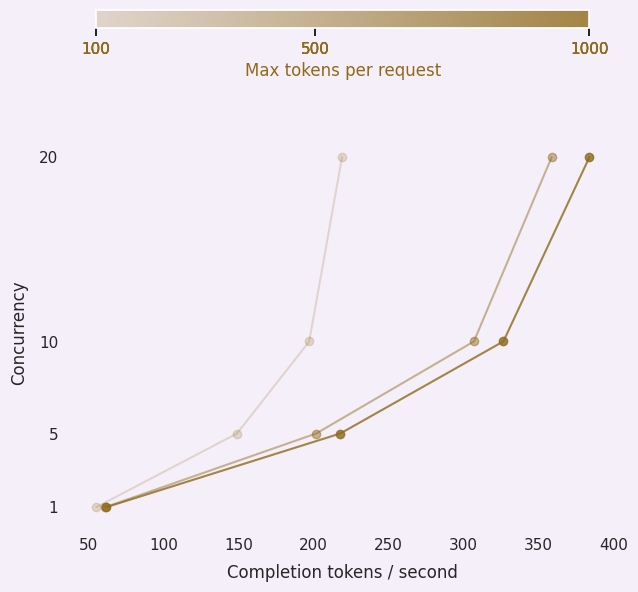

In [47]:
df['completion tokens / time'] = df.completion_tokens / df.total_time

fig, ax = plt.subplots(1,1,figsize=(7, 5))

alpha_bottom = .2
alpha_top = .8
max_token_alpha_map = create_mapping_function(
    df.max_tokens_per_request.min(), df.max_tokens_per_request.max(), 
    _max = alpha_top, _min = alpha_bottom
)
max_tokens_alphas = [max_token_alpha_map(v) for v in df.max_tokens_per_request]
request_map_for_colorbar = create_alpha_colormap(REQUEST_COLOR, alpha_bottom, alpha_top)

for v in df.max_tokens_per_request.unique():
    _df = df[df.max_tokens_per_request==v]
    a = max_token_alpha_map(v)
    ax.scatter(
        _df['completion tokens / time'], _df['concurrent_requests'], 
        color=REQUEST_COLOR, 
        alpha=a
    )
    spline = UnivariateSpline(_df['completion tokens / time'], _df['concurrent_requests'], s=10)
    _y = spline(_df['completion tokens / time'])
    ax.plot(
        _df['completion tokens / time'],
        _y, 
        alpha = a, 
        color = REQUEST_COLOR,
    )

request_ticks = df.concurrent_requests.unique()
divider = make_axes_locatable(ax)
x_start = df['completion tokens / time'].min()
x_dist = df['completion tokens / time'].max() - df['completion tokens / time'].min()
factor = request_ticks.max() * .35
y_start = request_ticks.max() + factor
y_dist = factor // 7
cax = ax.inset_axes([x_start, y_start, x_dist, y_dist], transform=ax.transData)
cbar = fig.colorbar(sm, orientation='horizontal', cax=cax)
cbar.set_ticks(max_tokens_alphas)
cbar.set_ticklabels([str(int(max_tpr)) for max_tpr in df.max_tokens_per_request], color=REQUEST_COLOR)
cbar.set_label('Max tokens per request', color=REQUEST_COLOR)

specific_concurrency_ticks = df.concurrent_requests.unique()
specific_concurrency_tick_labels = [str(int(tick)) for tick in specific_concurrency_ticks]
ax.set_yticks(specific_concurrency_ticks)
ax.set_yticklabels(specific_concurrency_tick_labels)
ax.set_ylabel('Concurrency', labelpad=LABELPAD)
ax.set_xlabel('Completion tokens / second', labelpad=LABELPAD)

plt.show()

In [51]:
spline.derivatives()

TypeError: derivatives() missing 1 required positional argument: 'x'

In [120]:
words_per_token = 0.75
words_in_a_page = 500
seconds_per_hour = 3600

print(f"(Estimated) number of document pages processed is {round(p_tokens * words_per_token * (1 / words_in_a_page))}.")
print(f"(Estimated) number of summary pages generated is {round(c_tokens * words_per_token * (1 / words_in_a_page))}.")
print(f"Billable compute time is {round(df.total_time.sum() / 3600, 3)} {device} hours.")

(Estimated) number of document pages processed is 51502.

(Estimated) number of summary pages generated is 5103.

Billable compute time is 3.464 NVIDIA A100-PCIE-40GB hours.

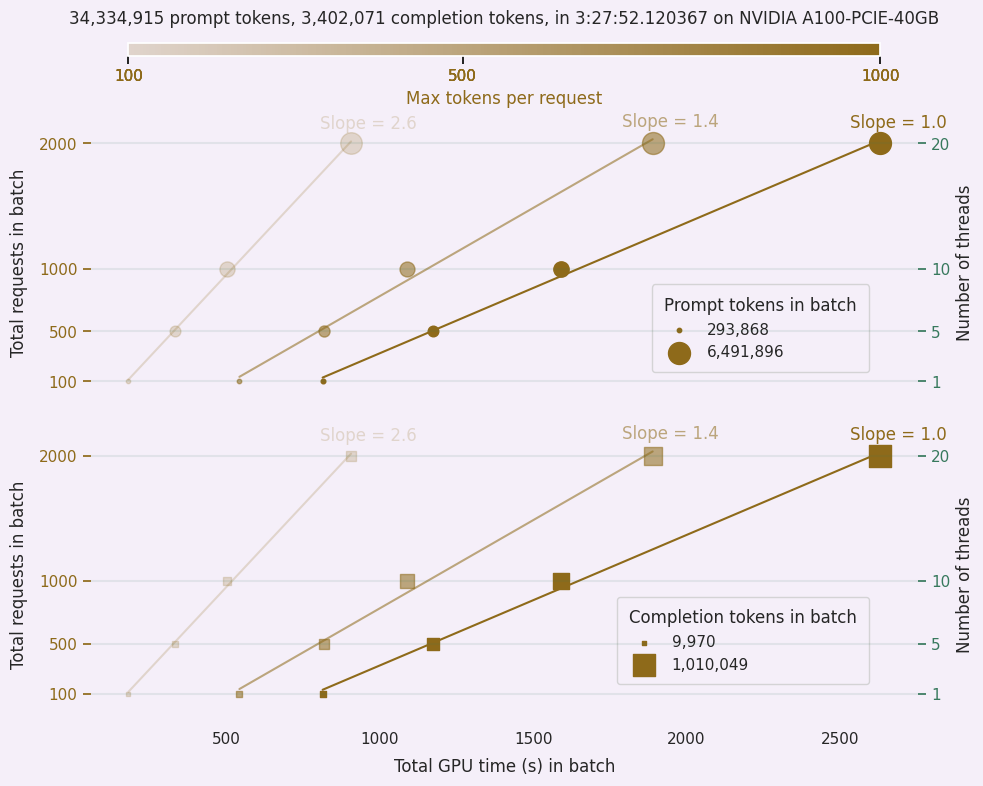

In [131]:
fig, ax = plt.subplot_mosaic(mosaic=[
    [ 'time and tokens - prompt' ],
    [ 'time and tokens - completion'] 
], figsize=(10,8))

alpha_bottom = .2
alpha_top = 1.
max_token_alpha_map = create_mapping_function(
    df.max_tokens_per_request.min(), df.max_tokens_per_request.max(), 
    _max = alpha_top, _min = alpha_bottom
)
max_tokens_alphas = [max_token_alpha_map(v) for v in df.max_tokens_per_request]
request_map_for_colorbar = create_alpha_colormap(REQUEST_COLOR, alpha_bottom, alpha_top)

max_prompt_tokens = df.prompt_tokens.max()
min_prompt_tokens = df.prompt_tokens.min()
prompt_map = create_mapping_function(a=min_prompt_tokens, b=max_prompt_tokens)
prompt_tokens_size_scaling = [prompt_map(p_tokens) for p_tokens in df.prompt_tokens]
prompt_tokens_size_scaling_labels = [
    f"{p:,}"
    for p in [min_prompt_tokens, max_prompt_tokens]
]

max_completion_tokens = df.completion_tokens.max()
min_completion_tokens = df.completion_tokens.min()
completions_map = create_mapping_function(a=min_completion_tokens, b=max_completion_tokens)
completion_tokens_size_scaling = [completions_map(c_tokens) for c_tokens in df.completion_tokens]
completion_tokens_size_scaling_labels = [
    f"{c:,}"
    for c in [min_completion_tokens, max_completion_tokens]
]

request_ticks = df.total_requests.unique()
specific_request_tick_labels = [str(int(tick)) for tick in request_ticks]
specific_concurrency_ticks = df.concurrent_requests.unique()
specific_concurrency_tick_labels = [str(int(tick)) for tick in specific_concurrency_ticks]

def color_ax(handle='time and tokens - prompt', is_prompt=True, is_bottom=False):

    # Cbar only if bottom
    if is_bottom:
        ax[handle].set_xlabel(f'Total GPU time (s) in batch', labelpad=LABELPAD)
    else:
        ax[handle].set_title(title, y=1.3)
        ax[handle].set_xticks([])
        divider = make_axes_locatable(ax[handle])
        x_start = df.total_time.min()
        x_dist = df.total_time.max() - df.total_time.min()
        factor = request_ticks.max() * .35
        y_start = request_ticks.max() + factor
        y_dist = factor // 7
    
        cax = ax[handle].inset_axes([x_start, y_start, x_dist, y_dist], transform=ax[handle].transData)
        cbar = fig.colorbar(sm, orientation='horizontal', cax=cax)
        cbar.set_ticks(max_tokens_alphas)
        cbar.set_ticklabels([str(int(max_tpr)) for max_tpr in df.max_tokens_per_request], color=REQUEST_COLOR)
        cbar.set_label('Max tokens per request', color=REQUEST_COLOR)
        
    # ax[handle].yaxis.label.set_color(REQUEST_COLOR)
    ax[handle].tick_params(axis='y', colors=REQUEST_COLOR)
    ax[handle].set_ylabel('Total requests in batch', labelpad=LABELPAD)
    ax[handle].set_yticks(request_ticks)
    ax[handle].set_yticklabels(specific_request_tick_labels)

    ax_time_tokens_twin = ax[handle].twinx()
    ax_time_tokens_twin.set_ylabel('Number of threads')
    # ax_time_tokens_twin.yaxis.label.set_color(CONCURRENCY_COLOR)
    ax_time_tokens_twin.tick_params(axis='y', colors=CONCURRENCY_COLOR)
    ax_time_tokens_twin.set_yticks(specific_concurrency_ticks)
    ax_time_tokens_twin.set_yticklabels(specific_concurrency_tick_labels, color=CONCURRENCY_COLOR)

    if is_prompt:
        for t, r, a, s in zip(
            df.total_time, df.total_requests, max_tokens_alphas, prompt_tokens_size_scaling
        ):
            ax[handle].scatter(
                t, 
                r, 
                marker='o',
                color = REQUEST_COLOR, 
                s = s,
                alpha = a
            )
    else:
        for t, r, a, s in zip(
            df.total_time, df.total_requests, max_tokens_alphas, completion_tokens_size_scaling
        ):
            ax[handle].scatter(
                t, 
                r, 
                marker='s',
                color = REQUEST_COLOR, 
                s = s,
                alpha = a
            )
        
    
    for val in df.max_tokens_per_request.unique():
        _df = df[df.max_tokens_per_request == val]
        a = max_token_alpha_map(val)
        slope, intercept = np.polyfit(_df.total_time, _df.total_requests, deg=1)
        _y = _df.total_time * slope + intercept
        ax[handle].plot(
            _df.total_time, 
            _y, 
            alpha = a, 
            color = REQUEST_COLOR,
        )
        x_pos = _df.total_time.values[-1]
        x_pos -= 0.05 * request_ticks.max()
        y_pos = _y.values[-1]
        y_pos *= 1.05
        ax[handle].text(x_pos, y_pos, f"Slope = {round(slope, 1)}", fontsize=12, color=REQUEST_COLOR, alpha=a)

    if is_prompt:
        handles = [
            ax[handle].scatter([], [], s=prompt_map(min_prompt_tokens), color=REQUEST_COLOR, marker='o'),
            ax[handle].scatter([], [], s=prompt_map(max_prompt_tokens), color=REQUEST_COLOR, marker='o')
        ]
        leg = ax[handle].legend(
            handles, 
            prompt_tokens_size_scaling_labels, 
            title="Prompt tokens in batch",
            bbox_to_anchor=(.95, 0.45),
            borderpad=0.8
        )
    else:
        handles = [
            ax[handle].scatter([], [], s=completions_map(min_completion_tokens), color=REQUEST_COLOR, marker='s'),
            ax[handle].scatter([], [], s=completions_map(max_completion_tokens), color=REQUEST_COLOR, marker='s')
        ]
        leg = ax[handle].legend(
            handles, 
            completion_tokens_size_scaling_labels, 
            title="Completion tokens in batch",
            bbox_to_anchor=(.95, 0.45),
            borderpad=0.8
        )
    
    leg._legend_box.align = "left"
    
    _10pct = request_ticks.max() * .1
    ax[handle].set_ylim([request_ticks.min() - _10pct, request_ticks.max() + _10pct])
    
    for val in specific_concurrency_ticks:
        ax_time_tokens_twin.axhline(y=val, alpha=0.1, color=CONCURRENCY_COLOR)
    
    _10pct = specific_concurrency_ticks.max() * .1
    ax_time_tokens_twin.set_ylim(
        [specific_concurrency_ticks.min() - _10pct, specific_concurrency_ticks.max() + _10pct]
    )


color_ax(handle='time and tokens - prompt', is_prompt=True, is_bottom=False)
color_ax(handle='time and tokens - completion', is_prompt=False, is_bottom=True)
fig.tight_layout()
plt.show()

In [135]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
formatted_device = device.lower().replace(' ', '_')
fig.savefig(f'results_{formatted_device}_{now}.png')
fig.savefig(f'results_{formatted_device}_{now}_transparent.png', transparent=True)

### Promotheus

In [85]:
PROMETHEUS_URL = 'http://localhost:9090/'
START_TIME = datetime.utcnow() - timedelta(hours=3) 
END_TIME = datetime.utcnow()
STEP = '15s'                         # Query step size

QUERIES = [
    'num_request_running',
    'gpu_cache_gpu_perc',
    'num_requests_waiting',
    'generation_tokens_total',
    'prompt_tokens_total',
    'request_prompt_tokens_sum',
    'time_to_first_token_seconds_sum',
]

def to_unix_timestamp(dt):
    return int(dt.timestamp())


In [86]:
def prometheus_to_dataframe(result, metric_name):
    if 'data' in result and 'result' in result['data']:
        records = []
        for metric in result['data']['result']:
            metric_labels = metric['metric']
            for value in metric['values']:
                timestamp = datetime.fromtimestamp(value[0])
                value = float(value[1])
                record = {'timestamp': timestamp, 'value': value, 'metric': metric_name}
                record.update(metric_labels)
                records.append(record)
        return pd.DataFrame(records)
    else:
        print(f"No data found for query: {metric_name}")
        return pd.DataFrame()

In [87]:
def query_prometheus(query, start_time=None, end_time=None, step=None):
    url = f"{PROMETHEUS_URL}/api/v1/query"
    params = {'query': query}

    if start_time and end_time and step:
        url = f"{PROMETHEUS_URL}/api/v1/query_range"
        params.update({
            'start': to_unix_timestamp(start_time),
            'end': to_unix_timestamp(end_time),
            'step': step
        })
        
    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

In [88]:
all_dataframes = []
for query in QUERIES:
    result = query_prometheus(query, start_time=START_TIME, end_time=END_TIME, step=STEP)
    df = prometheus_to_dataframe(result, query)
    all_dataframes.append(df)
combined_df = pd.concat(all_dataframes, ignore_index=True)

In [89]:
combined_df

,timestamp,value,metric,__name__,instance,job,model_name
0,2024-06-08 20:13:05,0.000000,num_requests_waiting,num_requests_waiting,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
1,2024-06-08 20:13:20,0.000000,num_requests_waiting,num_requests_waiting,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
2,2024-06-08 20:13:35,0.000000,num_requests_waiting,num_requests_waiting,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
3,2024-06-08 20:13:50,0.000000,num_requests_waiting,num_requests_waiting,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
4,2024-06-08 20:14:05,0.000000,num_requests_waiting,num_requests_waiting,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
...,...,...,...,...,...,...,...
3600,2024-06-08 23:12:05,5088.926343,time_to_first_token_seconds_sum,time_to_first_token_seconds_sum,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
3601,2024-06-08 23:12:20,5088.926343,time_to_first_token_seconds_sum,time_to_first_token_seconds_sum,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
3602,2024-06-08 23:12:35,5088.926343,time_to_first_token_seconds_sum,time_to_first_token_seconds_sum,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l
3603,2024-06-08 23:12:50,5088.926343,time_to_first_token_seconds_sum,time_to_first_token_seconds_sum,localhost:8000,prometheus,/tmp/meta--llama3-8b-instruct-p_cmc43l


In [91]:
list(combined_df.metric.unique())

['num_requests_waiting',
 'generation_tokens_total',
 'prompt_tokens_total',
 'request_prompt_tokens_sum',
 'time_to_first_token_seconds_sum']

### Observations

* More tokens per request --> More 